##  Linear Regression

 we will implement a linear regression model and the SGD algorithm. We will use the SGD algorithm to train our model, on synthetic and real-life dataset, and evaluate it's preformance. We will also get familiar with **numpy** and **pytorch**.

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from copy import deepcopy
import random
from torch.utils.data import Dataset
import torch
from tqdm import tqdm

### Dataset

Now we will create a dataset with that will produces samples which will follow these equation:
$$
\hat{y} = \vec{m}\vec{x} + n +\alpha.
$$
for a given $\vec{m}$, n, and $\alpha$ is a random noise samples from Gaussian distribution of mean 0 and variance 0.5. 

In [322]:
class LinearDataset(Dataset):
    """
    A dataset returning x and y using the linear equation.
    The x values should be sample from 0-1 uniformly.
    """
    def __init__(self, num_samples, m, n):
        """
        :param num_samples: Number of samples (labeled images in the dataset)
        :param m: The ground truth affline transformation 
        :param n: The ground truth bais
        """
        super().__init__()
        self.num_samples = num_samples
        self.m = m
        self.n = n
        
        # ====== YOUR CODE: ======
        self.x = np.random.uniform(size=self.num_samples)
        self.x = self.x.astype(np.float32)
        self.y = m * self.x + n + np.random.randn(self.num_samples)

        # ========================
        
    def __getitem__(self, index):
        # ====== YOUR CODE: ======
        return self.x[index], self.y[index]
        # ========================

    def __len__(self):
        # ====== YOUR CODE: ======
        return len(self.x)
        # ========================

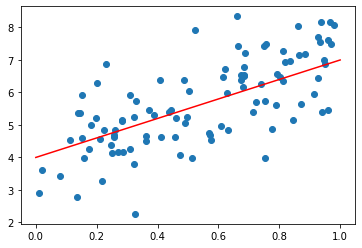

In [323]:
linear_ds = LinearDataset(100, np.array([3]),np.array([4]))
X = []
y = []
for _x,_y in linear_ds:
    X.append(_x) 
    y.append(_y)
plt.scatter(X, y)
line_x = np.linspace(0, 1., 100)
plt.plot(line_x, 4 +3*line_x, c='red')


Let's create our data loader

In [324]:
linear_dl = torch.utils.data.DataLoader(linear_ds,
                                        batch_size=100,
                                        shuffle=True)

### Linear Regression model

Let's Create our linear Regression model.
We are given a dataset $\left\{\vec{x}^{(i)}, y^{(i)}\right\}_{i=1}^{N}$ where $\vec{x}^{(i)} \in {R}^D$
is a $D$-dimensional feature vector and $y^{(i)}\in{R}$ is a continuous quantity assumed to be the
output of some unknown function, i.e. $y^{(i)} = f(\vec{x}^{(i)})$.

Our goal will be to fit a linear transformation,
parametrized by weights vector and bias term $\vec{w}, b$, such that given a sample $\vec{x}$ our prediction is 

$$
\hat{y} = \vec{w}\vec{x} + b.
$$

In order to make the implementation easier, it is common to concatenate column of ones to the input x, add expand the dimention of w by 1. This will lead to the same model structure, but we can write (and implement) now 
$$
\hat{y} = \vec{w^{*}}\vec{x^{*}}
$$



###### **From now on (till the end of this notebook), you should *use only* pytorch function !**
**You *should not use* torch.nn class at all (specially do not use torch.nn.Linear)!** 

In [325]:
# SGD for Linear Regression
class MyLinearRegression(torch.nn.Module):
    
    def __init__(self, input_dim, lr = 0.001):
        super(MyLinearRegression, self).__init__()
        self.lr = lr
        # ====== YOUR CODE: ======
        #initial randomly the model weights (torch.rand)
        self.w = torch.rand(input_dim + 1)
        # ========================
  
    def forward(self, x):
        # ====== YOUR CODE: ======
        # implemet the forward pass
        y_pred = []
        x = x.reshape(-1,1)
        for sample in x:    
          biased = torch.cat((sample, torch.Tensor([1])))
           
          y =  torch.dot(self.w , biased) 
          y_pred.append(y)
        # ========================
        return torch.Tensor(y_pred)
    
    def update_weights(self, weights_derv):
        # ====== YOUR CODE: ======
        # implemet update rule:
        self.w = self.w + self.lr * weights_derv
        
        # ========================
        
    def get_weights(self):
        return deepcopy(self.w)

We'll judge the performance of the model using the ordinary least-squares sense,
i.e. with a loss function of given by the mean-squared error (MSE): 

$$
L(\vec{w})
= \frac{1}{N} \sum_{i=1}^{N} \left( y^{(i)} - \hat{y}^{(i)} \right)^2
= \frac{1}{N} \sum_{i=1}^{N} \left( y^{(i)} - \vec{w^{*}}\vec{x^{*}}^{(i)} \right)^2 
$$

Minimizing the above $L(\vec{w})$ can have a closed-form solution. In this assignment it will be solved using iterative descent methods which
are necessary when the data is too large to fit in memory.



In [326]:
def MSELoss( outputs ,targets):
    # ====== YOUR CODE: ======
    #implemet the MSE function
    loss = 0
    for index, _ in enumerate(outputs):
      loss += (targets[index] - outputs[index])**2
    loss = loss / len(targets)
    # ========================
    return loss

#### The Gradient Descent Algorithm

Imagine a valley and a person with no sense of direction who wants to get to the bottom of the valley. He goes down the slope and takes large steps when the slope is steep and small steps when the slope is less steep. He decides his next position based on his current position and stops when he gets to the bottom of the valley which was his goal.

![img](https://miro.medium.com/max/3600/1*N5WjbzwsCFse-KPjBWZZ6g.jpeg)

Gradient descent is an iterative optimization algorithm to find the minimum of a function that follows this logic. At each step we will derive our loss with respect to w:

$$
D(\vec{w})
= \frac{2}{N} \sum_{i=1}^{N} \left( y^{(i)} - \vec{w^{*}}\vec{x^{*}}^{(i)} \right)\vec{-x^{*}}^{(i)}
= \frac{-2}{N} \sum_{i=1}^{N} \vec{x^{*}}^{(i)} \left( y^{(i)} - \vec{w^{*}}\vec{x^{*}}^{(i)} \right)
$$

Then we will update our weights by this equation:

![img](https://cdn-images-1.medium.com/max/484/1*lIthvknHt9Tok5aIj4e__g.png)


where alpha is our learning rate which determine the step size we took. 
Let's implement our loss function's derivative

Implement the derivative of MSELoss

In [327]:

def MSELossDerv(x, outputs ,target):
    # ====== YOUR CODE: ======
    # Implement the MSE derivative 
    # Don't forget to add column of 1s to x here as well!
    
    
    x= x.reshape(-1,1)
    
    x = torch.cat((x, torch.ones(len(target)).reshape(-1,1)),1)
    mse = outputs - target
    
    loss_derv = (-2 / len(target)) * torch.matmul(mse.float() , x.float() )
    
    # ========================
    return loss_derv

Now we will train our model on this dataset

In [328]:
def train(model, dataloader, n_epochs):
    history_loss = []
    history_lines = []
    for epoch in tqdm(range(n_epochs)):
        for x, targets in dataloader:
            outputs = model(x)
            loss = MSELoss(outputs ,targets)
            loss_derv = MSELossDerv(x, outputs ,targets)
            model.update_weights(loss_derv)
        if epoch%5==0:
            
            history_loss.append(loss/len(X))
            history_lines.append(model.get_weights())
    return model, history_loss, history_lines

### Finetuning learning rate 

We will train for 500 epochsm and finetune the learning rate. 

Run this following cells and explain the exhibited differences:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 220.59it/s]


Model convergence to the following weights: 
w = 0.9788237810134888, b = 0.6499364972114563


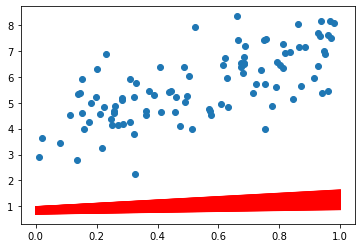

In [329]:
linear_regression_model = MyLinearRegression(1, 0.0001)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 500)

# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:


convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")

plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 190.06it/s]


Model convergence to the following weights: 
w = 1.719948172569275, b = 3.3958215713500977


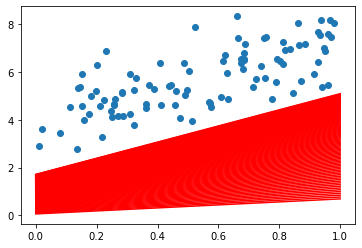

In [330]:
linear_regression_model = MyLinearRegression(1, 0.001)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 500)
# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:
convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")

plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 228.67it/s]


Model convergence to the following weights: 
w = 2.9732506275177, b = 4.058273792266846


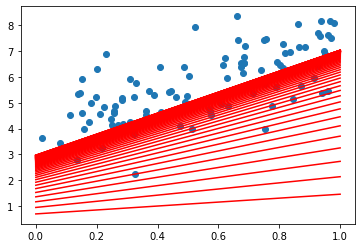

In [331]:
linear_regression_model = MyLinearRegression(1, 0.01)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 500)
# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:
convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")

plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

**QUESTION 1:** how does the training process change due to different values of learning rate?

**ANSWER:** Smaller learning rates require more training epochs given the smaller changes made to the weights each update,   whereas larger learning rates result in rapid changes and require fewer training epochs

### Finetuning number of epochs:

We will train with learning rate of 0.005 and finetune the number of epochs. 

Run this following cells and explain the exhibited differences:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 223.67it/s]


Model convergence to the following weights: 
w = 2.4558467864990234, b = 3.6815366744995117


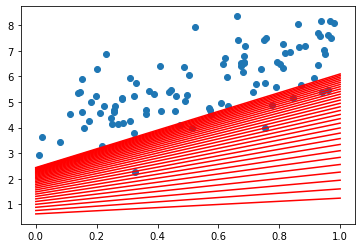

In [332]:
linear_regression_model = MyLinearRegression(1, 0.005)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 150)
# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:
convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")

plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 232.47it/s]


Model convergence to the following weights: 
w = 2.823812484741211, b = 4.1373372077941895


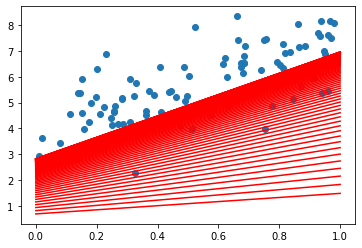

In [333]:
linear_regression_model = MyLinearRegression(1, 0.005)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 500)
# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:
convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")
 
plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 222.06it/s]


Model convergence to the following weights: 
w = 3.282447338104248, b = 3.881443977355957


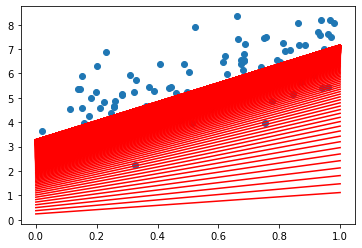

In [334]:
linear_regression_model = MyLinearRegression(1, 0.005)
trained_linear_regression_model, history_loss, history_lines = train(linear_regression_model, linear_dl, 5000)
# ====== YOUR CODE: ======
# Here it depends on your impementation, should be something like that:
convergenced_w, convergenced_b = linear_regression_model.get_weights()[0], linear_regression_model.get_weights()[1]
# ========================
print(f"Model convergence to the following weights: \nw = {convergenced_w}, b = {convergenced_b}")

plt.scatter(X, y)
for loss, line in zip(history_loss, history_lines):
  line_x = np.linspace(0, 1., 100)
  intercept = line[0]
  slope = line[1]
  plt.plot(line_x, intercept + slope*line_x, c='red')

**QUESTION 2:** how does the training process change due to the different values of epochs?

**ANSWER:** As the number of epochs increases, more number of times the weight are changed in the network and the line goes from underfitting to optimal to overfitting line.